We need to add 

(1) EM updates of the parameters of the prior on beta (spike + mixture of Gaussinans) ~ Theta, Theta_T; <br>
(2) Parameters of p y | z ~  gamma_{epsilon, t}. These are the parameters of the Weibull / Gumbell distributions for instance

In [2]:
from scipy.stats import norm
import numpy as np
import sympy
import scipy
import torch
from numpy import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# vampW code
# definition of Euler-Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

class prior:
    la = 0.5
    # Variances of the Gaussians in the mixture
    sigmas = [1]
    # Weights of the Gaussians in the mixture
    omegas = [1]
    def __init__(self, la, sigmas, omegas):
        self.la = la
        self.sigmas = sigmas
        self.omegas = omegas
    
def den_beta(r,gam1,prior): # checked!
    """
    This function returns the conditional expectation of the coefficients beta given the noisy estimate r
    The expectation is of the posterior distribution with the form of Spike and Slab mixture of Gaussians
    """
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))

    # How is this derived???
    # Is the sigma coming from the prior???
    # Note that gam1 * r / (gam1 + 1/sigma) = r / (1+1/(sigma*gam1)) = sigma * r / (sigma + 1/gam1)
    # This is equivalent to the formulation in the paper
    ratio = gam1 * r / (gam1 + 1/prior.sigmas[0]) * B / (A + B)
    return ratio



def der_den_beta(r,gam1,prior): # checked!
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio

def den_z_non_lin_eq(z, tau1, p1, y, alpha, mu): # checked!
    # This is the negative of what is in the Overleaf. Still, this needs to be = 0 so *=-1 doesn't change the outcome
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res
    
def den_z(p1, tau1, y, alpha, mu): # checked!
    """
    Performs component-wise optimization of the parameters z_i
    We assume independence of parameters of z_i 
    """
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

def der_den_z(p1, tau1, y, alpha, mu): # checked!
    # This is the second derivative of the expression g(z) to be maximized with the MAP estimation
    z = den_z(p1, tau1, y, alpha, mu)
    nom = tau1
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

# Simulate the outcomes Y
def sim_pheno(X, beta, mu, h2):
    # Isn't this logY_i = mu + xi.T beta + c(wi + emc)
    # logY_i = mu + xi.T beta + c(wi - Ewi), wi = - standard Gumbel distribution

    # beta is mx1 vector 
    # mu is nx1 vector 
    # h2 is the heritability parameter
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)

    varwi = np.pi * np.pi / 6
    
    # If h2 is heritability, this contradicts the initialization of alpha.
    # Why is this different from overleaf section "initialization of hyperparameter alpha?"
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    # c = np.sqrt((1-h2) * sigmaG / varwi)

    # Why does the - arise here?
    wi = -random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    # wi = random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    # c = 1 / a
    y = np.exp( mu + g + c * (wi + emc) )
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha
    
    

In [5]:
### WEIBULL MODEL ###
def update_Weibull_alpha_eq(alpha, y, mu, z_hat, xi):
    n,_ = y.shape
    out = np.zeros(n)
    res = np.log(y) - mu - z_hat
    out = np.sum(res) - np.exp(-emc) * np.sum( np.exp(alpha * res + (alpha**2)/2/xi) * (res + alpha/xi) )
    return out

def update_Weibull_alpha(y, mu, z_hat, alpha_old, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    alpha_new = scipy.optimize.fsolve(update_Weibull_alpha_eq, x0 = alpha_old, args=(y, mu, z_hat, xi))
    if isinstance(alpha_new, np.ndarray) or isinstance(alpha_new, list): alpha_new = float(alpha_new[0])
    return alpha_new

def update_Weibull_mu(y, z_hat, alpha, xi):
    # y.shape = [n,1]
    # z_hat.shape = [n,1]
    n,_ = y.shape
    mu_new = - np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat))))
    if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
    return mu_new

In [6]:
# Define the Weibull likelihood function in PyTorch
def weibull_likelihood(z_hat, Y, a, mu, xi, K):
    term1 = torch.exp(-a * mu - a * z_hat - K)
    term2 = Y ** a * torch.exp(a ** 2 / (2 * xi))
    term3 = a * torch.exp(a * z_hat + K) * mu
    term4 = (torch.exp(K) * a * z_hat - torch.exp(K) * torch.log(Y) * a + K * torch.exp(K)) * torch.exp(a * z_hat)
    term5 = torch.exp(a * mu)

    result = -term1 * (term2 + (term3 + term4) * term5)
    return torch.sum(result)

def update_params(optimizer, z_hat, Y, a, mu, xi, K):
    # Convert data to PyTorch tensors
    z_hat = torch.tensor(z_hat, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    xi = torch.tensor(xi, dtype=torch.float32)
    K = torch.tensor(K, dtype=torch.float32)

    # Optimization step
    for step in range(100):  # Number of optimization steps
        optimizer.zero_grad()
        loss = -weibull_likelihood(z_hat, Y, a, mu, xi, K)  # Negate to maximize
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item()}, a: {a.item()}, mu: {mu.item()}")

    print(f"Final a: {a.item()}, Final mu: {mu.item()}")
    return a.item(), mu.item()

In [47]:
import matplotlib.pyplot as plt

def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, prior)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu)
        # print("\n\n\n")
        # print(f"Alpha new: {alpha_new}; type: {type(alpha_new)}")
        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################

        beta_1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta-z1_hat)
        actual_xis.append(actual_xi)
        # alpha = torch.tensor(float(alpha), requires_grad=True)
        # mu = torch.tensor(float(mu), requires_grad=True)

        # optimizer = optim.Adam([alpha, mu], lr=0.01)
        
        # alpha, mu = update_params(optimizer, z1_hat, y, alpha, mu, 1e-4, K=emc)
        
        # alphas.append(alpha)
        # mus.append(mu)
        # alpha_new = update_Weibull_alpha(y, mu, z1_hat, alpha, 1/actual_xi)
        # if(not np.isnan(alpha_new)): 
        #     print(f"Changing alpha from {alpha} to {alpha_new}")
        #     alpha = alpha_new
        # alphas.append(alpha)




        
        def dl_dmu(y, z_hat, alpha, xi, mu):
            # Both return 0 successfully
            # result = mu -  update_Weibull_mu(y, z_hat, alpha, xi)
            # result = mu - (- np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat)))))
            # return result

            # mu = - np.log(n) / alpha - emc/alpha + alpha / 2 / xi + 1 / alpha * np.log(np.sum(np.exp(alpha*(np.log(y) - z_hat))))

            term1 = -emc
            term2 = (alpha ** 2) / (2 * xi)
            term3 = -alpha * mu
            sum_exp = np.sum(np.exp(alpha * (np.log(y) - z_hat)))
            
            result = np.exp(term1 + term2 + term3) * sum_exp - len(y)
            return result



        mu_new = update_Weibull_mu(y, z1_hat, alpha, actual_xi)
        if(not np.isnan(mu_new)):  
            print(f"Changing mu from {mu} to {mu_new}")
            mu = mu_new
        mus.append(mu_new)

        dl_dmus.append(dl_dmu(y, z1_hat, alpha, actual_xi, 0))
        # if isinstance(mu_new, np.ndarray) or isinstance(mu_new, list): mu_new = float(mu_new[0])
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")
            


    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus

n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

# These are the initial estimates
# gam1 = 1.0 / (sigma)
gam1 = 1e-2

print("gam1 = ", gam1)
pr = prior(la = la, sigmas = [sigma], omegas = [omega])
# mu = 0
mu = 0
# alpha = 2
print("Var(y) = ", np.var(y))
# tau1 = 1.0 / np.var(X @ beta)
tau1 = 1e-1
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])

maxiter = 10

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, p, dl_dmus = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)

gam1 =  0.01
Var(y) =  0.3283460653319947
tau1 =  0.1
alpha =  3.0543830649865034
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.8160483271920347
gam2 =  2.5225561565998147


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_13060/2467073728.py:60: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


corr(z1_hat, X*beta_true) =  0.5764656495634963
l2 error for z1_hat =  0.8896365679390842
v1 =  0.0707037084783848
true tau2 =  5.5801944911685455
tau2 = 1.3143529689191837
Changing mu from 0 to 0.19423604774521275
->LMMSE
corr(x2_hat, beta_true) =  [[0.44685337]]
l2 error for x2_hat =  0.9284335506208096
alpha2 =  0.8277860748625758
true gam1 =  2.1727671421695507
gam1 =  0.5247965752259709
corr(z2_hat, beta_true) =  [[0.66508735]]
l2 error for z2_hat =  0.7805997976754807
true tau1 =  6.760335074931671
tau1 =  6.3177416359180825


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [0.07326919]
corr(x1_hat, beta_true) =  0.4552725479133925
l2 error for x1_hat =  0.9408715518700206
B / (A+B) =  [0.37657606]
gam1 / (gam1 + 1/sigma) =  0.344174812399613
alpha1 part I =  [0.12960799]
alpha2 part II =  [0.01814605]
alpha1 =  0.13096212285461478
true gam2 =  2.82440459290068
gam2 =  3.48244279892929
corr(z1_hat, X*beta_true) =  0.7590162836940895
l2 error for z1_hat =  0.6680129401666002


In [ ]:
plt.figure(figsize=(20, 10))

# Plotting corr_x
plt.subplot(3, 4, 1)
plt.ylabel('corr_x')
plt.plot(range(len(corrs_x)), corrs_x, 'ro-')

# Plotting l2_err_x
plt.subplot(3, 4, 2)
plt.ylabel('l2_err_x')
plt.plot(range(len(l2_errs_x)), l2_errs_x, 'ro-')

# Plotting corr_z
plt.subplot(3, 4, 3)
plt.ylabel('corr_z')
plt.plot(range(len(corrs_z)), corrs_z, 'bo-')

# Plotting l2_err_z
plt.subplot(3, 4, 4)
plt.ylabel('l2_err_z')
plt.plot(range(len(l2_errs_z)), l2_errs_z, 'bo-')

# Plotting mu evolution
plt.subplot(3, 4, 5)
plt.ylabel('mu')
plt.plot(range(len(mus)), mus, 'go-')

# Plotting alpha evolution
plt.subplot(3, 4, 6)
plt.ylabel('alpha')
plt.plot(range(len(alphas)), alphas, 'go-')

# Plotting dL / dmu
plt.subplot(3, 4, 7)
plt.ylabel('dL / dmu')
plt.plot(range(len(dl_dmus)), dl_dmus, 'go-')



plt.tight_layout()
plt.show()

In [1]:
# Create an index array for the x-axis
indices = range(len(a))

# Plot actual values
plt.scatter(indices, a, color='blue', label='Actual')

# Plot predicted values
plt.scatter(indices, p, color='red', label='Predicted')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Scatter Plot')

# Add a legend
plt.legend()

# Display the plot
plt.show()

NameError: name 'a' is not defined

In [22]:
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
h2=0.95
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

In [23]:
# Assume X, beta, Y, alpha, mu, and emc are already defined
X = torch.tensor(X, dtype=torch.float32)
beta = torch.tensor(beta, dtype=torch.float32)
Y = torch.tensor(y, dtype=torch.float32)
alpha = torch.tensor(2.8, dtype=torch.float32)
mu = torch.tensor(0, dtype=torch.float32, requires_grad=True)
emc_t = torch.tensor(emc, dtype=torch.float32)
# result = weibull_likelihood(torch.tensor(X@beta), Y, alpha, 0.5, 1 / torch.var(torch.tensor(X@beta)), emc)
result = weibull_likelihood(torch.tensor(X@beta), Y, alpha, 0.5, 1 / torch.var(torch.tensor(X@beta)), emc_t)
result.item()

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/637086226.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = weibull_likelihood(torch.tensor(X@beta), Y, alpha, 0.5, 1 / torch.var(torch.tensor(X@beta)), emc_t)


-1845.7686767578125

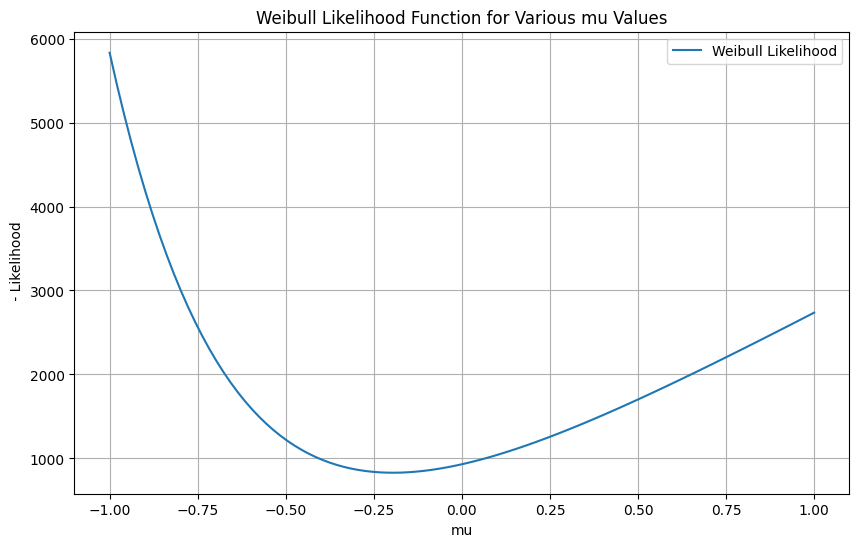

In [33]:
# Range of mu values
mu_values = np.linspace(-1, 1, 100)

# Calculate the likelihood for each value of mu
likelihood_values = [-weibull_likelihood(X@beta, Y, alpha, torch.tensor(mu, dtype=torch.float32), torch.tensor(1e10), emc_t) for mu in mu_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(mu_values, likelihood_values, label='Weibull Likelihood')
plt.xlabel('mu')
plt.ylabel(' - Likelihood')
plt.title('Weibull Likelihood Function for Various mu Values')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Convert data to torch tensors
X = torch.tensor(X, dtype=torch.float32)
beta = torch.tensor(beta, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
alpha = torch.tensor(alpha, dtype=torch.float32)
mu = torch.tensor(2.0, dtype=torch.float32, requires_grad=True)

# Calculate z_hat and xi
z_hat = torch.matmul(X, beta)
xi = 1 / torch.var(z_hat)

# Initialize optimizer
optimizer = torch.optim.Adam([mu], lr=0.1)

for j in range(100):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Recalculate the result
    result = -weibull_likelihood(z_hat, Y, alpha, mu, xi, emc_t)
    
    # Backpropagate the error
    result.backward()
    
    # Update the parameters
    optimizer.step()

    # Print the updated mu
    print(mu.item())

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/589130719.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/589130719.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_15539/589130719.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk7

1.899999976158142
1.8000065088272095
1.7000268697738647
1.600071668624878
1.500156283378601
1.4003026485443115
1.3005419969558716
1.2009187936782837
1.1014961004257202
1.0023634433746338
0.9036481976509094
0.8055325746536255
0.7082781195640564
0.612262487411499
0.5180336833000183
0.4263887405395508
0.3384811580181122
0.2559491693973541
0.18101823329925537
0.11645559221506119
0.06519334018230438
0.0295657180249691
0.010516690090298653
0.00734670227393508
0.01810375228524208
0.04019412398338318
0.07084520161151886
0.10735742747783661
0.14722654223442078
0.18821071088314056
0.22837521135807037
0.266120970249176
0.3001943826675415
0.32967787981033325
0.35396435856819153
0.3727210760116577
0.38584935665130615
0.39344489574432373
0.39576178789138794
0.3931819200515747
0.3861902356147766
0.37535494565963745
0.3613121509552002
0.3447529077529907
0.3264114558696747
0.3070523738861084
0.2874547243118286
0.2683917284011841
0.2506044805049896
0.2347702980041504
0.2214675396680832
0.211140871047973

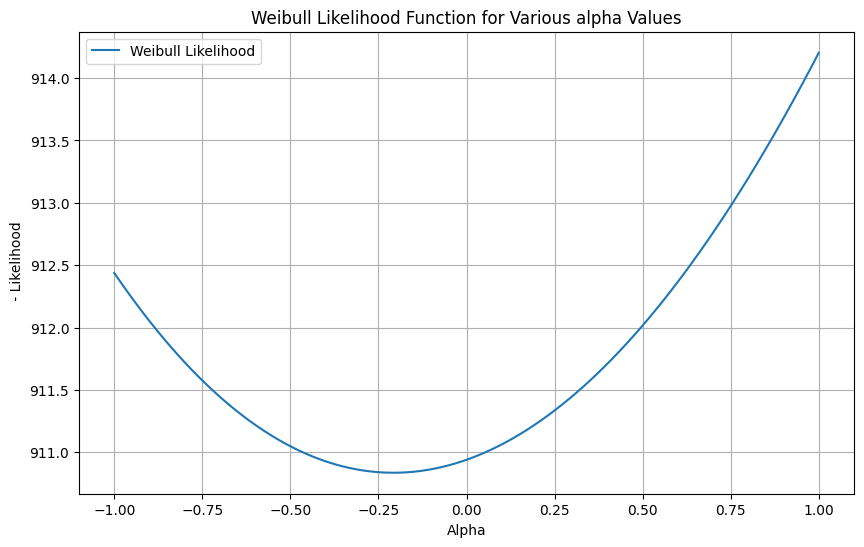

In [34]:
# Range of mu values
al_values = np.linspace(-1, 1, 100)

# Calculate the likelihood for each value of mu
likelihood_values = [-weibull_likelihood(X@beta, Y, torch.tensor(al, dtype=torch.float32), 0, torch.tensor(1e10), emc_t) for al in al_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(al_values, likelihood_values, label='Weibull Likelihood')
plt.xlabel('Alpha')
plt.ylabel(' - Likelihood')
plt.title('Weibull Likelihood Function for Various alpha Values')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Convert data to torch tensors
X = torch.tensor(X, dtype=torch.float32)
beta = torch.tensor(beta, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)
alpha = torch.tensor(2, dtype=torch.float32, requires_grad=True)
mu = torch.tensor(0, dtype=torch.float32)


# Calculate z_hat and xi
z_hat = torch.matmul(X, beta)
xi = 1 / torch.var(z_hat)

# Initialize optimizer
optimizer = torch.optim.Adam([alpha], lr=0.1)

for j in range(100):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Recalculate the result
    result = -weibull_likelihood(z_hat, Y, alpha, mu, xi, emc_t)
    
    # Backpropagate the error
    result.backward()
    
    # Update the parameters
    optimizer.step()

    # Print the updated mu
    print(alpha.item())

1.899999976158142
1.8004151582717896
1.701508641242981
1.6035300493240356
1.506713628768921
1.4112770557403564
1.317421317100525
1.2253303527832031
1.135171890258789
1.0470980405807495
0.9612465500831604
0.877741813659668
0.7966962456703186
0.7182115912437439
0.6423800587654114
0.5692855715751648
0.499004602432251
0.431607186794281
0.3671574294567108
0.3057140111923218
0.24733035266399384
0.19205458462238312
0.13992932438850403
0.09099109470844269
0.045269716531038284
0.0027873441576957703
-0.03644252568483353
-0.07241621613502502
-0.1051410585641861
-0.1346365362405777
-0.16093537211418152
-0.18408441543579102
-0.20414534211158752
-0.2211950421333313
-0.23532575368881226
-0.2466447949409485
-0.2552739381790161
-0.2613484859466553
-0.26501601934432983
-0.266434907913208
-0.2657725512981415
-0.263203501701355
-0.2589075267314911
-0.25306758284568787
-0.2458677887916565
-0.23749157786369324
-0.22811982035636902
-0.2179291993379593
-0.20709069073200226
-0.19576819241046906
-0.184117406606

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_13060/1200704033.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_13060/1200704033.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta = torch.tensor(beta, dtype=torch.float32)
/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_13060/1200704033.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


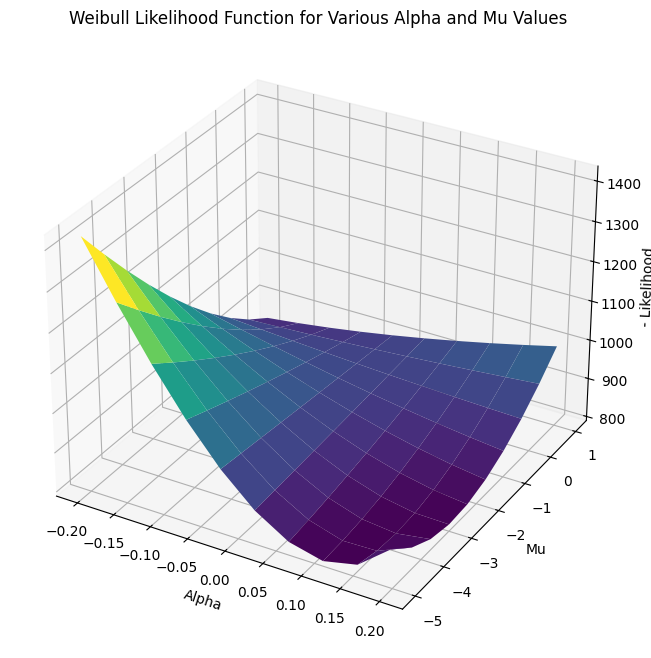

In [46]:

# Define the range of alpha and mu values
alpha_values = np.linspace(-0.2, 0.2, 10)  # Example range for alpha
mu_values = np.linspace(-5, 1, 10)      # Example range for mu


# Calculate the likelihood for each pair of alpha and mu
likelihood_values = np.zeros((len(alpha_values), len(mu_values)))

for i, alpha in enumerate(alpha_values):
    for j, mu in enumerate(mu_values):
        likelihood_values[i, j] = -weibull_likelihood(X@beta, Y, torch.tensor(alpha, dtype=torch.float32), torch.tensor(mu, dtype=torch.float32), 1/torch.var(X@beta), emc_t)

# Create the meshgrid for alpha and mu
alpha_grid, mu_grid = np.meshgrid(alpha_values, mu_values)

# Plotting the 3D surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_grid, mu_grid, likelihood_values.T, cmap='viridis')

ax.set_xlabel('Alpha')
ax.set_ylabel('Mu')
ax.set_zlabel(' - Likelihood')
ax.set_title('Weibull Likelihood Function for Various Alpha and Mu Values')

plt.show()

In [7]:
# old_prior = pr
def update_Prior(old_prior, r1, gam1):
    print(old_prior.sigmas.shape)
    print(old_prior.omegas.shape)
    prior = old_prior
    r1 = np.asmatrix(r1)
    omegas = np.transpose(np.asmatrix(old_prior.omegas))
    sigmas = np.transpose(np.asmatrix(old_prior.sigmas))
    sigmas_max = np.max(old_prior.sigmas)
    gam1inv = 1.0/gam1
    # np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv)) has shape = (P,L) and  omegas / np.sqrt(gam1inv + sigmas) has shape = (1, L)
    t1 = np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv))
    t2 = omegas / np.sqrt(gam1inv + sigmas)
    beta_tilde=np.multiply( t1, t2 )
    sum_beta_tilde = beta_tilde.sum(axis=1)
    beta_tilde=beta_tilde / sum_beta_tilde
    # pi.shape = (P, 1)
    pi = 1.0 / ( 1.0 + (1-prior.la * np.exp(-np.power(np.transpose(r1),2) / 2 * sigmas_max * gam1 / (sigmas_max + gam1inv) ) / np.sqrt(gam1inv) ) / sum_beta_tilde )
    gamma = np.divide(np.transpose(r1) * gam1, gam1 + 1.0/sigmas )
    # v.shape = (1,L)
    v = 1.0 / (gam1 + 1.0/sigmas)

    #updating sparsity level
    prior.la = np.mean(pi)
    #updating variances in the mixture
    prior.sigmas = (np.transpose(pi) @ np.multiply( beta_tilde , (np.power(gamma,2) + v)) ) / (np.transpose(pi) @ beta_tilde)
    #updating prior probabilities in the mixture
    prior.omegas = (np.transpose(pi) @ beta_tilde ) / np.sum(pi)
    return prior

In [8]:
def den_beta_mixture(r, gam1, prior):
    """
    Actually computes a mixture of Gaussians instead of just one Gaussian 
    """
    # By treating the coefficients beta_i as independent, we work with 1d Gaussians only.
    
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    A_der = A * (-r * gam1)

    B_tot = 0
    ratio_der = 0
    B_tot_der = 0
    for e, pi in zip(prior.sigmas, prior.omegas):
        B = pi * prior.la * norm.pdf(r, loc=0, scale=np.sqrt(e + 1.0/gam1))
        B_tot += B
        # Derivative of term1
        # Compute the derivative of B as the sum of derivatives of the individual terms
        B_der = B * (-r / (e + 1.0/gam1))
        num_term1 = B * e / (e + 1/gam1)
        num_term2 = B_der * e * r / (e + 1/gam1)
        B_tot_der += num_term1 + num_term2


    # Derivative of ratio
    ratio = B / (A + B)
    ratio_der = (B_tot_der * A - A_der * B_tot) / (A+B) / (A+B)
    
    return ratio, ratio_der

In [11]:
def den_beta_mixture(r, gam1, prior):
    """
    Actually computes a mixture of Gaussians instead of just one Gaussian 
    """
    # By treating the coefficients beta_i as independent, we work with 1d Gaussians only.
    
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    A_der = A * (-r * gam1)

    B_tot = 0
    ratio_der = 0
    B_tot_der = 0
    for e, pi in zip(prior.sigmas, prior.omegas):
        B = pi * prior.la * norm.pdf(r, loc=0, scale=np.sqrt(e + 1.0/gam1))
        B_tot += B
        # Derivative of term1
        # Compute the derivative of B as the sum of derivatives of the individual terms
        B_der = B * (-r / (e + 1.0/gam1))
        num_term1 = B * e / (e + 1/gam1)
        num_term2 = B_der * e * r / (e + 1/gam1)
        B_tot_der += num_term1 + num_term2


    # Derivative of ratio
    ratio = B / (A + B)
    ratio_der = (B_tot_der * A - A_der * B_tot) / ((A+B)**2)
    
    return ratio, ratio_der

In [ ]:
def der_den_beta(r,gam1,prior): # checked!
    # Derivative of the Gaussians with respect to r
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    print(A.shape)
    print(r.shape)
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio